# Reading data

In [26]:
import pandas as pd

In [27]:
data = pd.read_csv("../spam.csv", encoding = "ISO-8859-1")

# Data Cleaning

In [28]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [29]:
data

v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
...         ...        ...  
5567        NaN        NaN  
5568        NaN        NaN  
5569        NaN        NaN  
5570        NaN        NaN  
5571        NaN        NaN  

[5572 rows x 5 columns]

In [30]:
columns_to_drop = ['Unnamed: 2',"Unnamed: 3","Unnamed: 4"]
data.drop(columns_to_drop,inplace=True, axis=1)

In [31]:
data

v1                                                 v2
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham              Will Ì_ b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

In [32]:
def clean_text(text):
    # remove punctuations from text
    punctuations_removed = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(punctuations_removed)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    #stemming the tokens
    stemmed = [porter.stem(word) for word in words]
    final_text = ' '.join(stemmed)
    return final_text

In [33]:
data['v2'] = data['v2'].apply(clean_text)

In [34]:
data

v1                                                 v2
0      ham  go jurong point crazi avail bugi n great world...
1      ham                              ok lar joke wif u oni
2     spam  free entri wkli comp win fa cup final tkt may ...
3      ham                u dun say earli hor u c alreadi say
4      ham          nah dont think goe usf live around though
...    ...                                                ...
5567  spam  time tri contact u u pound prize claim easi ca...
5568   ham                            ì b go esplanad fr home
5569   ham                            piti mood soani suggest
5570   ham  guy bitch act like id interest buy someth els ...
5571   ham                                     rofl true name

[5572 rows x 2 columns]

#  RVM classifier

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn import metrics

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data['v2'], data['v1'], test_size = 0.2, random_state = 2)

In [37]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

# converting text to numerical representation


In [38]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['v2'])
X_train = Tfidf_vect.transform(X_train)
X_test = Tfidf_vect.transform(X_test)

# Building RVM CLassifier from sklearn module



!pip install https://github.com/JamesRitchie/scikit-rvm/archive/master.zip


In [39]:
X_train = X_train.toarray()

import time
start = time.time()

from skrvm import RVC
clf = RVC(kernel='linear')
clf.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")


import pickle

pickle.dump(clf, open("../models/RVC_spam_classification_model_imbalanced_data", 'wb'))

# load the model from disk

In [40]:
import pickle
loaded_model = pickle.load(open("../models/RVC_spam_classification_model_imbalanced_data", 'rb'))

In [41]:
y_pred = loaded_model.predict(X_test)

In [42]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
test_result_data = pd.read_csv("../results/test_result_data_with_RVMR_SVM_NaiveBayes_LSTM_KNN_Majority_based_voting_imbalanced.csv")
test_result_data['RVMC prediction'] = y_pred
test_result_data.to_csv("../results/test_result_data_with_RVMC_RVMR_SVM_NaiveBayes_LSTM_KNN_Majority_based_voting_imbalanced.csv")

## Evaluate model



In [44]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9775784753363229


# Use loaded model for predictiing to new data

In [45]:
# Predict for unseen data
test_data = "Congratulations. You have won a lottery of 1,00,000 pounds. Please click here to claim this lottery."
cleaned_test_data = clean_text(test_data)
test_data_embedding = Tfidf_vect.transform([cleaned_test_data])

In [46]:
test_data_embedding = test_data_embedding.toarray()
test_data_prediction = loaded_model.predict(test_data_embedding)[0].item()

In [47]:
def get_result(prediction_label):
    if prediction_label == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [48]:
get_result(test_data_prediction)

Message is SPAM


## Visualizing evaluation metrics

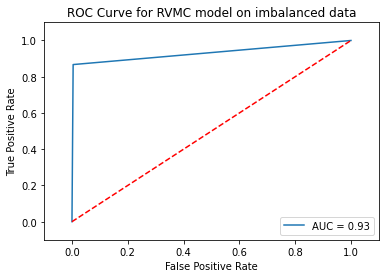

In [49]:
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve for RVMC model on imbalanced data')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.savefig('../results/rvmc_roc_imbalaanced.jpg')
plt.show()


In [50]:
import itertools
import numpy as np
matrix = confusion_matrix(y_test,y_pred)

plt.clf()

# place labels at the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# plot the matrix per se
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

# plot colorbar to the right
plt.colorbar()

fmt = 'd'

# write the number of predictions in each bucket
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):

    # if background is dark, use a white number, and vice-versa
    plt.text(j, i, format(matrix[i, j], fmt),
         horizontalalignment="center",
         color="white" if matrix[i, j] > thresh else "black")

class_names = ['ham','spam']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label',size=14)
plt.xlabel('Predicted label',size=14)
plt.savefig('../results/rvmc_confusion_matrix_imbalanced.jpg')
plt.show()


# Implement k fold cross validation



from sklearn.model_selection import KFold
import numpy as np


Encoder = LabelEncoder()
y = Encoder.fit_transform(data['v1'])
X= data['v2']
X = np.array(X)
kf = KFold(n_splits=10, random_state=4, shuffle=True)


from sklearn.metrics import classification_report

accuracy_list = []
for train_index,test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    Tfidf_vect.fit(X_train)
    
    X_train = Tfidf_vect.transform(X_train)
    X_test = Tfidf_vect.transform(X_test)
    
    X_train = X_train.toarray()
    clf = RVR(kernel='linear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred = y_pred.tolist()
    rvm_predictions = []
    for pred in y_pred:
        if pred < 0.5:
            rvm_predictions.append(0)
        else:
            rvm_predictions.append(1)
    print(confusion_matrix(y_test, rvm_predictions))
    print(classification_report(y_test, rvm_predictions))
    accuracy = metrics.accuracy_score(y_test, rvm_predictions)
    accuracy_list.append(accuracy)
    print("Accuracy in this fold is",accuracy)
    
    print('\n')

accuracy_list = [i*100 for i in accuracy_list]

fold_list = [1,2,3,4,5,6,7,8,9,10]

import matplotlib.pyplot as plt
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes = plt.gca()
axes.set_ylim([95,100])
# axes.set_xlim([0,4])
axes.xaxis.set_ticks(np.arange(0, 11, 1))
models = fold_list
accuracy_scores = accuracy_list
axes.bar(models,accuracy_scores)
plt.xlabel('Folds')
plt.ylabel('Accuracy Scores')
plt.title('K fold cross validation results of rvm model')
fig.savefig('../results/k_fold_cross_validation_result_rvm.jpg', bbox_inches='tight')

# plt.savefig('results/comparision_chart.png')
plt.show()
